## Load the Raw Data <a class="anchor" id="load-data"></a>

Loading utility functions in the `load_data.py` file located in the `src/data` directory.

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd
from pandas.io.stata import StataReader

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

# Adding local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from data import load_data
from features import process_features

## Inspect and Clean Data <a class="anchor" id="inspect"></a>

Starting out with loading the data for Malawi. 

The survey data used in this project has few issues:

1. Several entries in the `ind_educ09` column of the Malawi individual data had duplicate labels for Primary and Secondary school choices: "CHURCH/MISSION SCHOOL" and "ISLAMIC SCHOOL", which raises an error when pandas attempts to convert categoricals. This is fixed by setting the `update_education` parameter by appending primary and secondary the the labels. 

1. A small number of records in the Malawi household dataset have missing values in one or more columns (< 10). Since this is a very small number, these are dropped using the `drop_minornans` parameter.

In [2]:
def load_stata_file(filepath, 
                    index_cols, 
                    update_education=False, 
                    drop_minornans=False, 
                    drop_unlabeled=False):
    """ Load data and metadata from Stata file"""
    data = pd.read_stata(filepath, convert_categoricals=False).set_index(index_cols)

    with StataReader(filepath) as reader:
        reader.value_labels()
            
        mapping = {col: reader.value_label_dict[t] for col, t in 
                   zip(reader.varlist, reader.lbllist)
                   if t in reader.value_label_dict}

        # print(f'mapping----> {mapping}')
        
        # manually update some specific columns
        # in the Malawi dataset
        if update_education and 'ind_educ09' in mapping:
            mapping['ind_educ09'][13] = "Primary - " + mapping['ind_educ09'][13]
            mapping['ind_educ09'][14] = "Primary - " + mapping['ind_educ09'][14]
            
            mapping['ind_educ09'][23] = "Secondary - " + mapping['ind_educ09'][23]
            mapping['ind_educ09'][24] = "Secondary - " + mapping['ind_educ09'][24]
        
        data.replace(mapping, inplace=True)
        
        # convert the categorical variables into
        # the category type
        for c in data.columns:
            if c in mapping:
                data[c] = data[c].astype('category')
                        
        # drop records with only a few nans
        if drop_minornans: 
            nan_counts = (data.applymap(pd.isnull)
                          .sum(axis=0)
                          .sort_values(ascending=False))
            nan_cols = nan_counts[(nan_counts > 0) & (nan_counts < 10)].index.values
            data = data.dropna(subset=nan_cols)
        # drop unlabeled categorical values
        def find_unlabeled(x):
            if x.name in mapping.keys():
                return [val if (val in mapping[x.name].values() or pd.isnull(val)) 
                        else 'UNLABELED' for val in x]
            else:
                return x
            
        data = data.apply(find_unlabeled)
        data = data[~data.applymap(lambda x: x == "UNLABELED").any(axis=1)]
        
        # read the actual questions that were asked for reference
        questions = reader.variable_labels()
        
    return data, questions

First we'll load the Malawi data using the function above

In [3]:
# Load Malawi household data
filepath = load_data.MWI_HOUSEHOLD
mwi_hhold, mwi_hhold_questions = load_stata_file(filepath, 
                                                 ['hid'], 
                                                 drop_minornans=True, 
                                                 drop_unlabeled=True)

s = 'Malawi household data has {:,} rows and {:,} columns'
print(s.format(mwi_hhold.shape[0], mwi_hhold.shape[1]))
s = 'Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}'
print(s.format(mwi_hhold.poor.value_counts(normalize=True).loc['Poor'], 
               mwi_hhold.poor.value_counts(normalize=True).loc['Non-poor']))
mwi_hhold.head()

Malawi household data has 12,244 rows and 346 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,wta_hh,wta_pop,der_hhsize,poor,hld_dwelloccu,hld_dwelltype,hld_walls,hld_roof,hld_floor,hld_rooms,...,com_weeklymrkt,com_postoffice,com_publicphone,com_distprimary,com_classrooms,com_schoolelec,com_medicines,com_clinic,com_distclinic,com_bank
hid,,,,,,,,,,,,,,,,,,,,,
101010160009,126.560097,759.360596,6,Poor,Owned,Traditional,Compacted earth,Grass,Smoothed mud,2,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No
101010160033,126.560097,506.240387,4,Poor,Owned,Traditional,Compacted earth,Grass,Smoothed mud,3,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No
101010160060,126.560097,1265.600952,10,Poor,Owned,Semi-Permanent,Burnt bricks,Grass,Smoothed mud,6,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No
101010160068,126.560097,1139.040894,9,Poor,Owned,Traditional,Mud,Grass,Smoothed mud,3,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No
101010160069,126.560097,126.560097,1,Non-poor,Owned,Traditional,Mud brick,Grass,Smoothed mud,2,...,Yes,No,NO,NaN,Yes,No,No,No,21 to 25 kilometers,No


In [4]:
filepath = load_data.MWI_INDIVIDUAL
mwi_indiv, mwi_indiv_questions = load_stata_file(filepath, 
                                                 ['hid', 'iid'], 
                                                 update_education=True)

s = 'Malawi individual data has {:,} rows and {:,} columns'
print(s.format(mwi_indiv.shape[0], mwi_indiv.shape[1]))
s = 'Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}'
print(s.format(mwi_indiv.poor.value_counts(normalize=True).loc['Poor'], 
               mwi_indiv.poor.value_counts(normalize=True).loc['Non-poor']))
mwi_indiv.head(5)

Malawi individual data has 56,211 rows and 42 columns
Percent poor: 52.4% 	Percent non-poor: 47.6%


ind_sex         ind_relation  ind_age ind_educfath  \
hid          iid                                                      
101010160009 1    Female                 Head       31         PSLC   
             2      Male         Wife/Husband       35         PSLC   
             3    Female  Child/Adopted child       10          NaN   
             4      Male  Child/Adopted child        6          NaN   
             5    Female  Child/Adopted child        3          NaN   

                 ind_educmoth ind_language  ind_religion  \
hid          iid                                           
101010160009 1           NONE       Lambya  Christianity   
             2           NONE          NaN  Christianity   
             3            NaN          NaN           NaN   
             4            NaN          NaN           NaN   
             5            NaN          NaN           NaN   

                                              ind_marital ind_readwrite  \
hid          iid                                                          
101010160009 1    Monogamous, married or non formal union           Yes   
             2    Monogamous, married or non formal union           Yes   
             3                                        NaN            No   
             4                                        NaN            No   
             5                                        NaN            No   

                 ind_rwchichewa  ...             ind_birthplace  \
hid          iid                 ...                              
101010160009 1              Yes  ...  Hospital/maternity clinic   
             2              Yes  ...                        NaN   
             3               No  ...                        NaN   
             4               No  ...                        NaN   
             5              NaN  ...                        NaN   

                 ind_birthattend ind_work1 ind_work2 ind_work3 ind_work4  \
hid          iid                                                           
101010160009 1             Nurse       0.0       Yes       NaN        No   
             2               NaN       0.0       Yes       NaN        No   
             3               NaN       0.0       Yes       NaN        No   
             4               NaN       0.0       Yes       NaN        No   
             5               NaN       NaN       NaN       NaN        No   

                 ind_work5 ind_work6      wta_hh  poor  
hid          iid                                        
101010160009 1         NaN        No  126.560097  Poor  
             2         NaN        No  126.560097  Poor  
             3         NaN        No  126.560097  Poor  
             4         NaN        No  126.560097  Poor  
             5         NaN       NaN  126.560097  Poor  

[5 rows x 42 columns]

### Convert target variable, `poor`, to a Boolean


In [5]:
mwi_hhold.poor = (mwi_hhold.poor == 'Poor')

## Build derived features from individual data <a class="anchor" id="derived-features"></a>

The individual data gives a lot of additional information on each household that could be used as features.

In [7]:
# Show some individual features
pd.DataFrame.from_dict(mwi_indiv_questions, orient='index').head(10)

,0
hid,Unique HH Identifier
iid,Household Member ID Code
ind_sex,Sex
ind_relation,Relationship to Head
ind_age,How old is [NAME] (years)?
ind_educfath,What was the highest educational qualification...
ind_educmoth,What was the highest educational qualification...
ind_language,Which language do you speak at home?
ind_religion,"What religion, if any, does [NAME] practice"
ind_marital,What is [NAME]'s present marital status?


In [11]:
# q_temp = pd.DataFrame.from_dict(mwi_hhold_questions, orient= 'index')
mwi_hhold_questions['cons_0508']


'Chicken'

#### Common derived features:
* Number of children (age 10 and under) in household 
* Number of males in household (over 10 years old)
* Number of females in household (over 10 years old)
* Number of literate household members (over 10 years old)
* Number of household members employed in the past 12 months



In [45]:
def add_derived_feature(df, 
                        feature_name, 
                        values, 
                        questions_dict, 
                        question=None):
    '''Add a derived feature to the household dataframe and update questions'''
    df['der_' + feature_name] = values
    questions_dict['der_' + feature_name] = question
    return

In [46]:
# MWI - Number of children (10 and under) in household
values = (mwi_indiv.ind_age <= 10).sum(level=0).astype(int)
question = 'Number of children in household age 10 and under'
add_derived_feature(mwi_hhold, 
                    'nchild10under', 
                    values, 
                    mwi_hhold_questions, 
                    question=question)



/var/folders/px/bp9nx6057cv6t7g9910khmkr0000gn/T/ipykernel_70263/3002475470.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  values = (mwi_indiv.ind_age <= 10).sum(level=0).astype(int)


In [47]:
# MWI - Number of males and females in household over age 10
values = ((mwi_indiv.ind_sex == 'Male') & (mwi_indiv.ind_age > 10)).sum(level=0).astype(int)
question = 'Number of males in household over age 10'
add_derived_feature(mwi_hhold, 'nmalesover10', values, mwi_hhold_questions, question=question)
values = ((mwi_indiv.ind_sex == 'Female') & (mwi_indiv.ind_age > 10)).sum(level=0).astype(int)
question = 'Number of females in household over age 10'
add_derived_feature(mwi_hhold, 
                    'nfemalesover10', 
                    values, 
                    mwi_hhold_questions, 
                    question=question)


/var/folders/px/bp9nx6057cv6t7g9910khmkr0000gn/T/ipykernel_70263/3970758641.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  values = ((mwi_indiv.ind_sex == 'Male') & (mwi_indiv.ind_age > 10)).sum(level=0).astype(int)
/var/folders/px/bp9nx6057cv6t7g9910khmkr0000gn/T/ipykernel_70263/3970758641.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  values = ((mwi_indiv.ind_sex == 'Female') & (mwi_indiv.ind_age > 10)).sum(level=0).astype(int)


In [48]:
# MWI - Number of household members who can read and write in any language
values = (mwi_indiv.ind_readwrite == 'Yes').sum(level=0).astype(int)
question = 'Number of household members who can read and write'
add_derived_feature(mwi_hhold, 
                    'nliterate', 
                    values, 
                    mwi_hhold_questions, 
                    question=question)

# # IDN - Number of household members who can read and write in any language
# values = (idn_indiv.ind_educ11 == 'Yes').sum(level=0).astype(int)
# question = 'Number of household members who can read and write'
# add_derived_feature(idn_hhold, 
#                     'nliterate', 
#                     values, 
#                     idn_hhold_questions, 
#                     question=question)

/var/folders/px/bp9nx6057cv6t7g9910khmkr0000gn/T/ipykernel_70263/3610723620.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  values = (mwi_indiv.ind_readwrite == 'Yes').sum(level=0).astype(int)


In [49]:
# MWI - Number of household members employed in past 12 months
values = (mwi_indiv.ind_work4 == 'Yes').sum(level=0).astype(int)
question = 'Number of household members employed in past 12 months (over age 10)'
add_derived_feature(mwi_hhold, 
                    'nemployedpastyear', 
                    values,
                    mwi_hhold_questions,
                    question=question)

/var/folders/px/bp9nx6057cv6t7g9910khmkr0000gn/T/ipykernel_70263/1301264395.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  values = (mwi_indiv.ind_work4 == 'Yes').sum(level=0).astype(int)


## Dummy variables <a class="anchor" id="dummy-variables"></a>
Some classification algorithms are able to handle categorical variables easily, but others require the inputs to be numeric. When categorical variables are present, the preffered method is to create dummy variables. This takes the categorical feature and creates a new binary column for each value. To deal with `dummy variable trap` the first dummy variable for each categorical variable needs to be dropped. Also, removing features that are not useful for this classification problem, such as empty or constant columns and duplicate columns.

In [50]:
# create dummy variables for categoricals
mwi_hhold = pd.get_dummies(mwi_hhold, drop_first=True, dummy_na=True, prefix_sep='__')

print("Malawi household shape with dummy variables added", mwi_hhold.shape)

Malawi household shape with dummy variables added (12244, 816)


In [51]:
# remove columns with only one unique value (all nan dummies from columns with no missing values)
mwi_hhold = mwi_hhold.loc[:, mwi_hhold.nunique(axis=0) > 1]

print("Malawi household shape with constant columns dropped", mwi_hhold.shape)

Malawi household shape with constant columns dropped (12244, 527)


In [52]:
# remove duplicate columns - these end up being all from nan or Not Applicable dummies 
process_features.drop_duplicate_columns(mwi_hhold, ignore=['wta_hh', 'wta_pop'], inplace=True)

print("Malawi household shape with duplicate columns dropped", mwi_hhold.shape)

Malawi household shape with duplicate columns dropped (12244, 487)


## Data Exploration <a class="anchor" id="exploration"></a>


### Malawi Exploration

First, figuring out if there are any distinct relationships between features and the target variable. This can be done by plotting the distribution of features out against the target, or by calculating the correlation between each feature and the target.

In the Malawi data, there are only a few features that are not categoricals. In fact, all of the non-categorical features in this case are small integer responses, such as the number of individuals in the household. These could be consideresd as categoricals as well or can be binned into categorical ranges.

In [53]:
def plot_numeric_hist(df, 
                      col, 
                      x_label, 
                      y_label='Percentage of Households', 
                      target='poor', 
                      integer_ticks=True, 
                      ax=None):
    if ax is None:
        ax = plt.gca()
    
    df.groupby(df[target])[col].plot.hist(bins=np.arange(0, df[col].max()) - 1, 
                                          alpha=0.5, 
                                          density=True,
                                          
                                          ax=ax)
    # print(np.arange(0,df[col].max()+1))
    ax.set_xlim([0,df[col].max()])
    if integer_ticks:
        ax.set_xticks(np.arange(0,df[col].max()+ 1) + 0.5)
        ax.set_xticklabels(np.arange(0,df[col].max()+1, dtype=int))
        ax.xaxis.grid(False)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(title='poor')

Starting out by comparing the distributions of the numeric features between poor and non-poor responses. If the distributions are clearly separable, these features could be more useful as predictors.

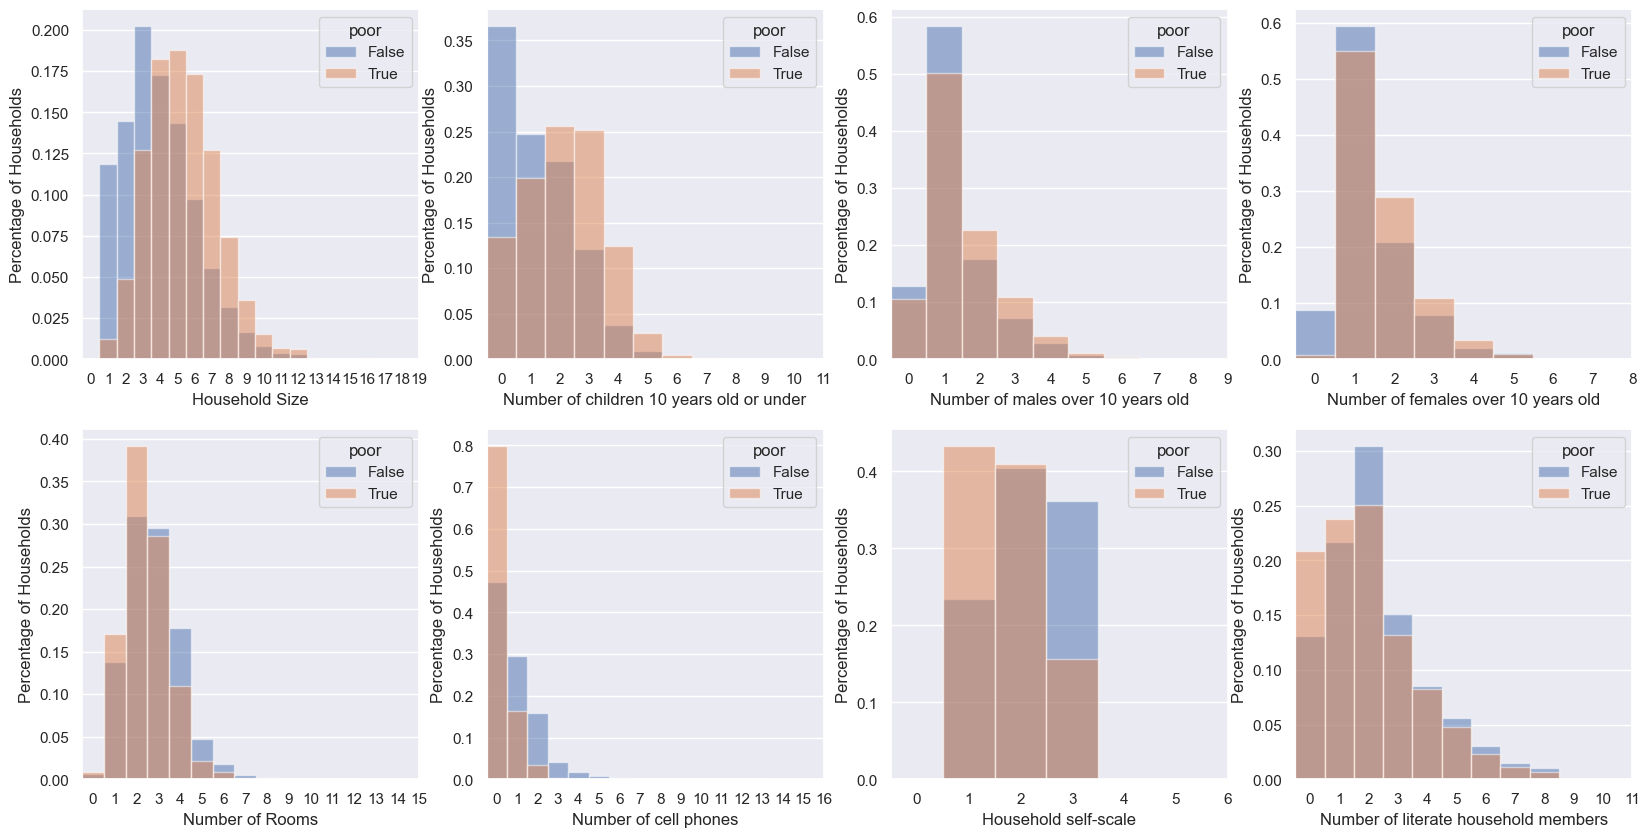

In [54]:
# Compare poor vs non-poor numeric features
#   We have 8 numeric features, so we make a 2x3 grid to plot them
fig, axes = plt.subplots(2, 4, figsize=(20,10))
plot_numeric_hist(mwi_hhold, 
                  'der_hhsize', 
                  'Household Size', 
                  ax=axes[0][0])
plot_numeric_hist(mwi_hhold, 
                  'der_nchild10under', 
                  'Number of children 10 years old or under', 
                  ax=axes[0][1])
plot_numeric_hist(mwi_hhold, 
                  'der_nmalesover10', 
                  'Number of males over 10 years old', 
                  ax=axes[0][2])
plot_numeric_hist(mwi_hhold, 
                  'der_nfemalesover10', 
                  'Number of females over 10 years old', 
                  ax=axes[0][3])
plot_numeric_hist(mwi_hhold, 
                  'hld_rooms', 
                  'Number of Rooms', 
                  ax=axes[1][0])
plot_numeric_hist(mwi_hhold, 
                  'hld_nbcellpho', 
                  'Number of cell phones', 
                  ax=axes[1][1])
plot_numeric_hist(mwi_hhold, 
                  'hld_selfscale', 
                  'Household self-scale', 
                  ax=axes[1][2])
plot_numeric_hist(mwi_hhold, 
                  'der_nliterate', 
                  'Number of literate household members', 
                  ax=axes[1][3])

plt.show()

From the histograms, it is clear that there is not a lot of distinct separation in the distribution of responses between poor and non-poor, except for possibly in the household size and the number of children under 10 years old. Therefor it can be expected that these features will have more of an impact as predictors. However, it is important to note that the number of children under 10 is just a subset of the household size, so only need to keep one of these features in our classifiers.

Let's find out which consumables appear most in the dataset. There are 212 consumables in the Malawi survey. It is a good idea to get a better understanding of which ones are most important for predicting if a household is poor and possibly reduce this number to 50 or less. 

First, we'll just look to see which consumables had the greatest number of "Yes" responses.

In [55]:
# Filter consumables and group by poor/non-poor
consumable_columns = [x for x in mwi_hhold.columns if x.startswith('cons_')]
consumables = (mwi_hhold.groupby('poor')[consumable_columns]
                        .sum()
                        .T)

consumables.columns = ['Non_poor', 'Poor']
consumables['total'] = consumables.sum(axis=1)
consumables['percent'] = consumables.total / mwi_hhold.shape[0]

# Match up the consumable names for readability
get_consumable_name = lambda x: mwi_hhold_questions[x.split('__')[0]]
consumables.index = consumables.index.map(get_consumable_name)

# Display the top 10 most common consumables
consumables.sort_values('percent', ascending=False).head(10)

,Non_poor,Poor,total,percent
Salt,6677,5471,12148,0.992159
"Milling fees, grain",6223,5238,11461,0.936050
Bar soap (body soap or clothes soap),6387,5027,11414,0.932212
Tomato,6105,4197,10302,0.841392
Matches,5810,4411,10221,0.834776
"Glycerine, Vaseline, skin creams",5888,4207,10095,0.824485
Dried fish,4798,3244,8042,0.656811
Cooking oil,5396,2571,7967,0.650686
Nkhwani,4316,3613,7929,0.647582
Sugar,5516,2393,7909,0.645949


<AxesSubplot: >

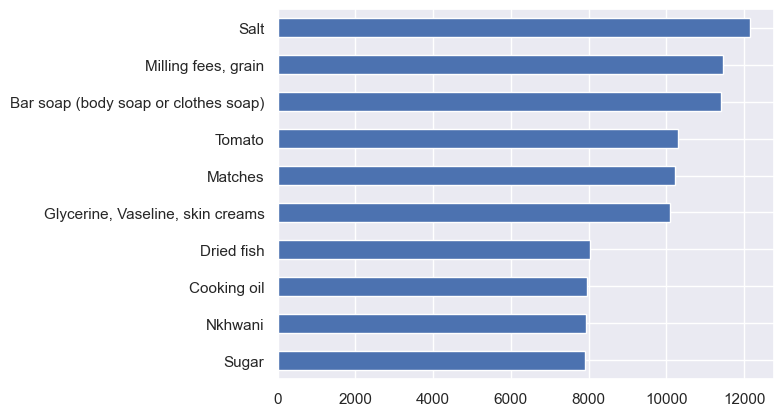

In [56]:
# Plot the top 10 most common consumables
(consumables.total
            .sort_values(ascending=False)
            .head(10)
            .sort_values(ascending=True).plot.barh())

The consumables that appear most often may simply be those that are common to both poor and non-poor households and may not be a great predictor of poverty. For instance, over 90% of households reported purchasing salt, grain, and bar soap regardless of their poverty status. 

What is potentially more interesting is consumables that appear more frequently in non-poor households compared to poor. If there is a large difference, this item may be an indicator of the household's poverty status.

In [57]:
# consumables.drop(consumables.loc[consumables.index.str.startswith('Other')].index, inplace=True)
consumables.loc[consumables.index.str.startswith('Other')]

,Non_poor,Poor,total,percent
Other (specify),15,10,25,0.002042
Other (specify),4,4,8,0.000653
Other (specify),24,23,47,0.003839
Other cultivated green leafy vegetables,988,886,1874,0.153055
Other vegetables (Specify),97,221,318,0.025972
"Other poultry - guinea fowl, doves, etc.",77,29,106,0.008657
Other (specify),31,18,49,0.004002
Other fruits (specify),52,38,90,0.007351
Other (specify),15,2,17,0.001388
Other (specify),3,5,8,0.000653


In [58]:
consumables.loc['Other (specify)']

,Non_poor,Poor,total,percent
Other (specify),15,10,25,0.002042
Other (specify),4,4,8,0.000653
Other (specify),24,23,47,0.003839
Other (specify),31,18,49,0.004002
Other (specify),15,2,17,0.001388
Other (specify),3,5,8,0.000653
Other (specify),1,6,7,0.000572
Other (specify),11,9,20,0.001633
Other (specify),20,9,29,0.002369


In [60]:
consumables['difference'] = np.where(consumables["Non_poor"] >= consumables["Poor"], (consumables.Non_poor - consumables.Poor) / consumables.total , np.nan)

# Display the top 20 most common consumables
display(consumables.sort_values('difference', ascending=False).head(20))

,Non_poor,Poor,total,percent,difference
Cheese,19,0,19,0.001552,1.000000
"Jam, jelly",32,0,32,0.002614,1.000000
Yoghurt,151,0,151,0.012333,1.000000
"Cocoa, millo",131,0,131,0.010699,1.000000
Butter,40,0,40,0.003267,1.000000
Night's lodging in rest house or hotel,62,0,62,0.005064,1.000000
Mortgage - regular payment to purchase house,5,0,5,0.000408,1.000000
Tomato sauce (bottle),74,0,74,0.006044,1.000000
Breakfast cereal,48,0,48,0.003920,1.000000
Bottled water,74,0,74,0.006044,1.000000


The list above is more interesting. In the majority of survey responses, the households reporting that they purchased these items were not poor.

## Create Train/Test Split and Save Data <a class="anchor" id="save-data"></a>

As a final step in pre-processing, the data will be split into training and test sets which will be used by all of the algorithms. Reserving 25% of the data as a test set. 


In [61]:
# Split Malawi data 
mwi_train, mwi_test = train_test_split(mwi_hhold, 
                                       test_size=0.25,
                                       random_state=1443,
                                       stratify=mwi_hhold.poor)

# Save data to files
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = load_data.get_country_filepaths('mwi')
mwi_train.to_pickle(TRAIN_PATH)
mwi_test.to_pickle(TEST_PATH)
with open(QUESTIONS_PATH, 'w') as fp:
    json.dump(mwi_hhold_questions, fp)

